<a href="https://colab.research.google.com/github/mikaelsouza/fraud-detection/blob/master/minst_imbalaced_gan_31_10_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import numpy as np
from sklearn import model_selection, preprocessing, metrics, utils
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [0]:
# Loading dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train / 255
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_test = X_test / 255


In [0]:
# Filtering dataset to use only 2 classes

def get_labeled_instances(X_data, y_data, wanted_label):
  filtered_data = []
  for data, label in zip(X_data, y_data):
    if label == wanted_label:
      filtered_data.append((data, label))
  new_X, new_y = zip(*filtered_data)
  new_X = np.array(new_X)
  new_y = np.array(new_y)
  return new_X, new_y

class_0, label_0 = get_labeled_instances(X_train, y_train, 0)
class_1, label_1 = get_labeled_instances(X_train, y_train, 1)

label_0 = label_0.reshape(-1, 1)
label_1 = label_1.reshape(-1, 1)

In [4]:
# Generating a imbalanced dataframe

imbalanced_class_0 = class_0[:200]
imbalanced_label_0 = label_0[:200]

imbalanced_data_0 = np.concatenate((imbalanced_class_0,
                                    imbalanced_label_0),
                                    axis=1)

imbalanced_data_1 = np.concatenate((class_1, label_1), axis=1)

print(imbalanced_data_0.shape)
print(imbalanced_data_1.shape)

columns = [*list(range(784)), 'class']

imbalanced_dataframe = pd.DataFrame(np.concatenate((imbalanced_data_0,
                                                    imbalanced_data_1)),
                                    columns=columns)

imbalanced_dataframe.head()

(200, 785)
(6742, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Function to get stratified samples
# https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas#
def stratified_sample(dataframe, feature, size):
  return dataframe.groupby(feature, group_keys=False).apply(lambda x: x.sample(min(len(x), size)))

In [6]:
# Defining Discriminator

optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

model = keras.models.Sequential()
model.add(Dense(1024, input_dim=784))
model.add(LeakyReLU(0.2))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(LeakyReLU(0.2))
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(LeakyReLU(0.2))
model.add(Dropout(0.3))

d_input = keras.layers.Input(shape=(784,))
d_output = Dense(3, activation='softmax')
d_model = d_output(model(d_input))

discriminator = keras.models.Model(d_input, d_model)
discriminator.compile(loss='categorical_crossentropy',
                      metrics=['acc'],
                      optimizer=optimizer)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256)               1459968   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 1,460,739
Trainable params: 1,460,739
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Defining Generator

sample_dim = 100
n_classes = 2


model = keras.models.Sequential()
model.add(Dense(256, input_dim=sample_dim))
model.add(LeakyReLU(0.2))
model.add(Dense(512))
model.add(LeakyReLU(0.2))
model.add(Dense(1024))
model.add(LeakyReLU(0.2))
model.add(Dense(784, activation='sigmoid'))

noise_input = keras.layers.Input(shape=(sample_dim,))
label = keras.layers.Input(shape=(1,))
label_embedding = keras.layers.Flatten()(keras.layers.Embedding(n_classes, sample_dim)(label))

g_input = keras.layers.multiply([noise_input, label_embedding])
g_output = keras.layers.Dense(784, activation='sigmoid')

g_model = g_output(model(g_input))

generator = keras.models.Model([noise_input, label], g_model)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       200         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
multiply_1

In [8]:
# Defining GAN

discriminator.trainable = False

noise = keras.layers.Input(shape=(100,))
label = keras.layers.Input(shape=(1,))
sample = generator([noise, label])

valid = discriminator(sample)

gan_model = keras.models.Model([noise, label], valid)
gan_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
gan_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 784)          2101992     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 3)            1460739     model_2[1][0]                    
Total para

In [9]:
# Defining other necessary variables

epochs = 10000
batch_size = 128

class_0 = [0]
class_1 = [1]
class_fake = [2]

onehot_class_0 = [0.9, 0.05, 0.05]
onehot_class_1 = [0.05, 0.9, 0.05]
onehot_fake = [0.05, 0.05, 0.9]

balanced_labels = np.array(class_0 * (batch_size // 2) + class_1 * (batch_size // 2)).reshape(-1, 1)
balanced_labels_onehot = np.array(onehot_class_0 * (batch_size // 2) + onehot_class_1 * (batch_size // 2)).reshape(-1, 3)
fake_labels_onehot = np.array(onehot_fake * batch_size).reshape(-1, 3)

X_train, y_train = imbalanced_dataframe.drop(['class'], axis=1), imbalanced_dataframe['class']
X_train = np.array(X_train).reshape(-1, 784)
y_train = y_train.reshape(-1, 1)
y_onehot = np.array([[0.9, 0.05, 0.05] if value[0] == 0 else [0.05, 0.9, 0.05] for value in y_train])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [0]:
def plot_mnist_value(sample):
  sample = sample * 255
  pixels = sample
  pixels = pixels.reshape((28, 28))
  plt.imshow(pixels, cmap='gray')
  plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.503537, acc.: 23.44%, Clf. classes reais acc.: 0.445312, Clf. classes fake acc.: 0.023438] [G loss: 1.377299]


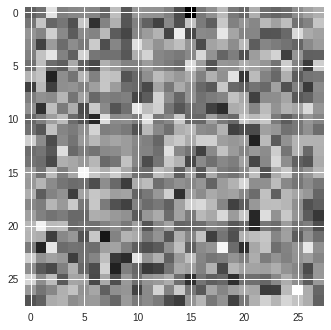

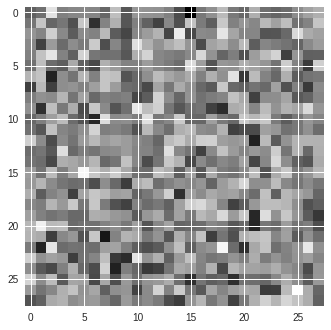

100 [D loss: 0.455059, acc.: 98.44%, Clf. classes reais acc.: 0.968750, Clf. classes fake acc.: 1.000000] [G loss: 3.157957]
200 [D loss: 0.427075, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 3.319065]
300 [D loss: 0.472591, acc.: 97.66%, Clf. classes reais acc.: 0.953125, Clf. classes fake acc.: 1.000000] [G loss: 3.306229]
400 [D loss: 0.430944, acc.: 98.44%, Clf. classes reais acc.: 0.968750, Clf. classes fake acc.: 1.000000] [G loss: 3.169694]
500 [D loss: 0.424233, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 3.168375]
600 [D loss: 0.426237, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 3.054415]
700 [D loss: 0.447552, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 3.157681]
800 [D loss: 0.479776, acc.: 95.70%, Clf. classes reais acc.: 0.914062, Clf. classes fake acc.: 1.000000] [G loss: 2.698660]

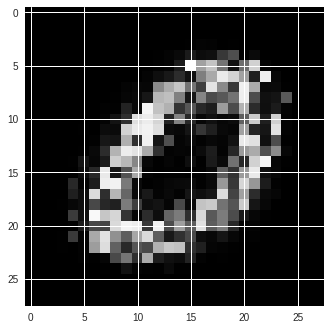

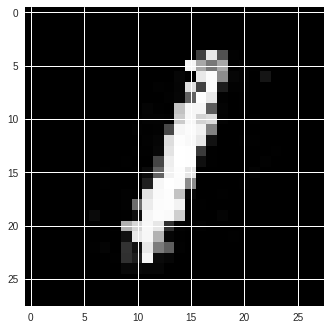

1100 [D loss: 0.424849, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 3.050425]
1200 [D loss: 0.421822, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 3.206896]
1300 [D loss: 0.424395, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 3.239187]
1400 [D loss: 0.429022, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 3.216833]
1500 [D loss: 0.410338, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 3.072301]
1600 [D loss: 0.414339, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 3.066163]
1700 [D loss: 0.408929, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 3.028302]
1800 [D loss: 0.411015, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss:

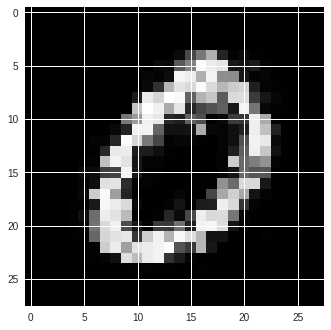

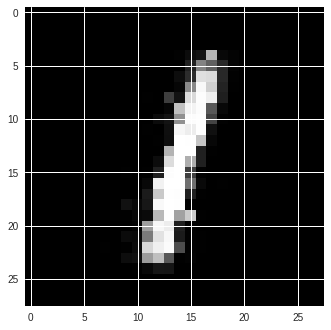

2100 [D loss: 0.422664, acc.: 98.83%, Clf. classes reais acc.: 0.976562, Clf. classes fake acc.: 1.000000] [G loss: 2.953973]
2200 [D loss: 0.408103, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 2.903784]
2300 [D loss: 0.408692, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.949674]
2400 [D loss: 0.409857, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.931240]
2500 [D loss: 0.423357, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 3.174390]
2600 [D loss: 0.407318, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 2.857281]
2700 [D loss: 0.413732, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.906374]
2800 [D loss: 0.409088, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 

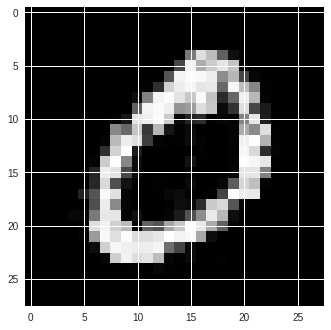

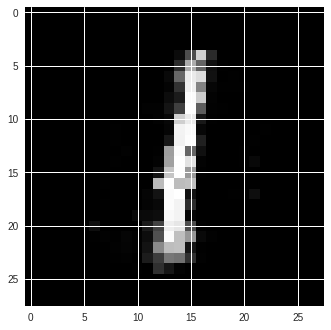

3100 [D loss: 0.428775, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 3.274231]
3200 [D loss: 0.406229, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 2.884536]
3300 [D loss: 0.407220, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 2.854005]
3400 [D loss: 0.407385, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 3.018738]
3500 [D loss: 0.407389, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 3.027783]
3600 [D loss: 0.428334, acc.: 98.44%, Clf. classes reais acc.: 0.976562, Clf. classes fake acc.: 0.992188] [G loss: 2.887199]
3700 [D loss: 0.408442, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.931567]
3800 [D loss: 0.409459, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss:

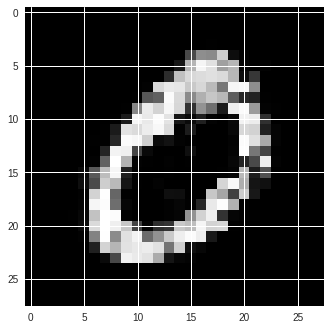

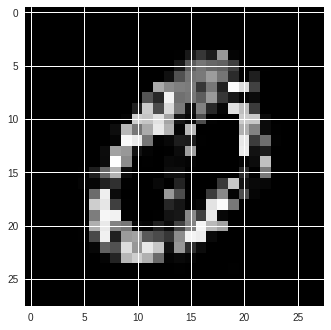

4100 [D loss: 0.408765, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.798990]
4200 [D loss: 0.430555, acc.: 98.44%, Clf. classes reais acc.: 0.968750, Clf. classes fake acc.: 1.000000] [G loss: 2.743276]
4300 [D loss: 0.405822, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 2.948756]
4400 [D loss: 0.418947, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.958272]
4500 [D loss: 0.421762, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 3.154352]
4600 [D loss: 0.417574, acc.: 98.83%, Clf. classes reais acc.: 0.976562, Clf. classes fake acc.: 1.000000] [G loss: 2.945786]
4700 [D loss: 0.419981, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.946190]
4800 [D loss: 0.420820, acc.: 98.83%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 0.992188] [G loss: 2

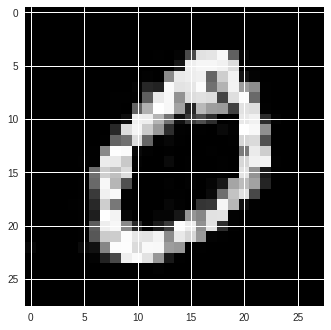

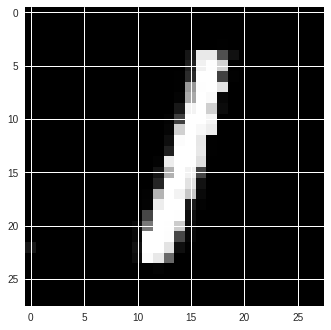

5100 [D loss: 0.428280, acc.: 98.44%, Clf. classes reais acc.: 0.968750, Clf. classes fake acc.: 1.000000] [G loss: 2.815438]
5200 [D loss: 0.409423, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.847974]
5300 [D loss: 0.422559, acc.: 99.22%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 0.992188] [G loss: 2.943670]
5400 [D loss: 0.430032, acc.: 98.83%, Clf. classes reais acc.: 0.976562, Clf. classes fake acc.: 1.000000] [G loss: 2.958718]
5500 [D loss: 0.429947, acc.: 98.05%, Clf. classes reais acc.: 0.960938, Clf. classes fake acc.: 1.000000] [G loss: 2.935642]
5600 [D loss: 0.410735, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.834679]
5700 [D loss: 0.427663, acc.: 98.05%, Clf. classes reais acc.: 0.976562, Clf. classes fake acc.: 0.984375] [G loss: 3.092328]
5800 [D loss: 0.412288, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.

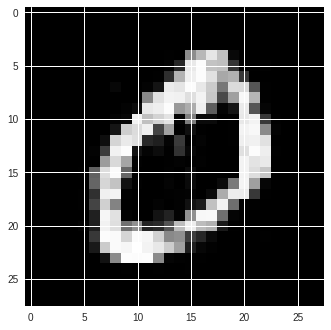

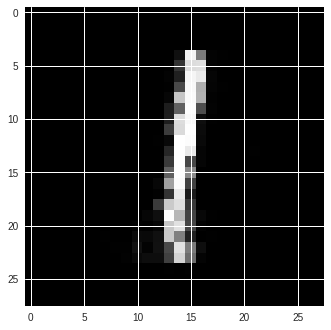

6100 [D loss: 0.438286, acc.: 98.44%, Clf. classes reais acc.: 0.968750, Clf. classes fake acc.: 1.000000] [G loss: 2.703610]
6200 [D loss: 0.430243, acc.: 98.44%, Clf. classes reais acc.: 0.968750, Clf. classes fake acc.: 1.000000] [G loss: 3.096905]
6300 [D loss: 0.417910, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.914109]
6400 [D loss: 0.404977, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.824327]
6500 [D loss: 0.436559, acc.: 98.05%, Clf. classes reais acc.: 0.960938, Clf. classes fake acc.: 1.000000] [G loss: 2.776884]
6600 [D loss: 0.443031, acc.: 98.05%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 0.976562] [G loss: 3.052550]
6700 [D loss: 0.415422, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.870876]
6800 [D loss: 0.418680, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.

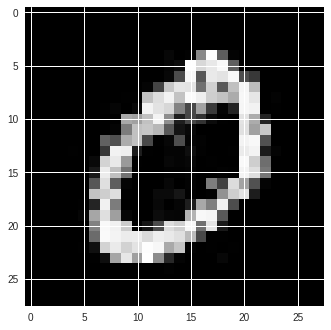

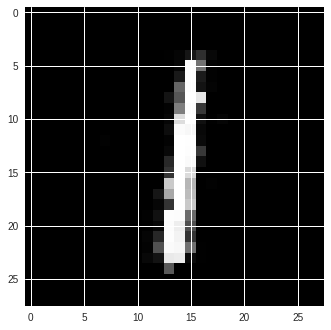

7100 [D loss: 0.414978, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.825908]
7200 [D loss: 0.412535, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.962574]
7300 [D loss: 0.437801, acc.: 98.44%, Clf. classes reais acc.: 0.968750, Clf. classes fake acc.: 1.000000] [G loss: 2.875729]
7400 [D loss: 0.406143, acc.: 100.00%, Clf. classes reais acc.: 1.000000, Clf. classes fake acc.: 1.000000] [G loss: 2.814287]
7500 [D loss: 0.443077, acc.: 97.27%, Clf. classes reais acc.: 0.968750, Clf. classes fake acc.: 0.976562] [G loss: 3.357969]
7600 [D loss: 0.428527, acc.: 97.66%, Clf. classes reais acc.: 0.960938, Clf. classes fake acc.: 0.992188] [G loss: 2.790173]
7700 [D loss: 0.447396, acc.: 96.88%, Clf. classes reais acc.: 0.960938, Clf. classes fake acc.: 0.976562] [G loss: 2.810009]
7800 [D loss: 0.411139, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2

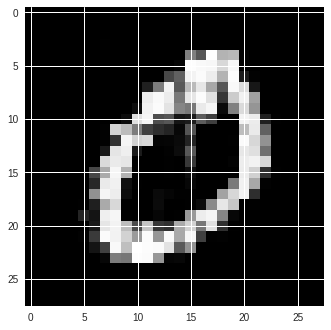

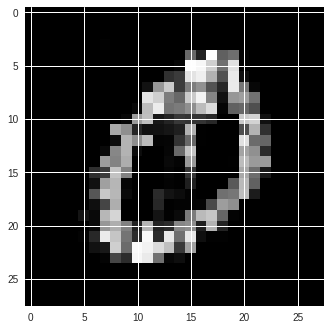

8100 [D loss: 0.417041, acc.: 98.83%, Clf. classes reais acc.: 0.976562, Clf. classes fake acc.: 1.000000] [G loss: 2.813733]
8200 [D loss: 0.416738, acc.: 98.83%, Clf. classes reais acc.: 0.976562, Clf. classes fake acc.: 1.000000] [G loss: 3.011160]
8300 [D loss: 0.415261, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.861210]
8400 [D loss: 0.416052, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.798926]
8500 [D loss: 0.432515, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.979240]
8600 [D loss: 0.425097, acc.: 98.44%, Clf. classes reais acc.: 0.968750, Clf. classes fake acc.: 1.000000] [G loss: 2.760586]
8700 [D loss: 0.410840, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.775353]
8800 [D loss: 0.420784, acc.: 99.22%, Clf. classes reais acc.: 0.984375, Clf. classes fake acc.: 1.000000] [G loss: 2.

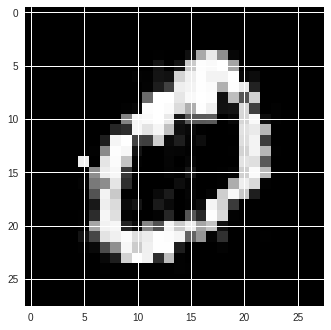

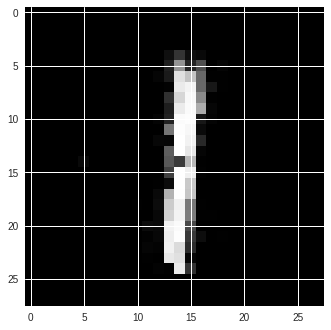

9100 [D loss: 0.414245, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.779054]
9200 [D loss: 0.415839, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.767492]
9300 [D loss: 0.414999, acc.: 98.83%, Clf. classes reais acc.: 0.976562, Clf. classes fake acc.: 1.000000] [G loss: 2.788592]
9400 [D loss: 0.412287, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.996080]
9500 [D loss: 0.429142, acc.: 98.83%, Clf. classes reais acc.: 0.976562, Clf. classes fake acc.: 1.000000] [G loss: 2.780127]
9600 [D loss: 0.429205, acc.: 98.05%, Clf. classes reais acc.: 0.968750, Clf. classes fake acc.: 0.992188] [G loss: 3.143393]
9700 [D loss: 0.412415, acc.: 99.61%, Clf. classes reais acc.: 0.992188, Clf. classes fake acc.: 1.000000] [G loss: 2.785841]
9800 [D loss: 0.441803, acc.: 97.66%, Clf. classes reais acc.: 0.953125, Clf. classes fake acc.: 1.000000] [G loss: 2.

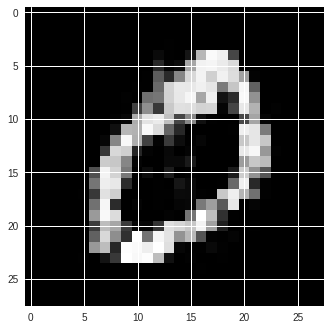

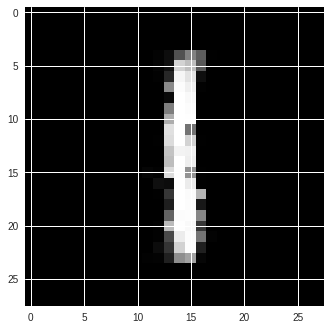

In [11]:
for epoch in range(epochs + 1):
  train_sampled = stratified_sample(imbalanced_dataframe, 'class', batch_size // 2)
  idx = train_sampled.index
  samples, labels, labels_onehot = X_train[idx], y_train[idx], y_onehot[idx]
  
  noise_array = np.random.normal(0, 1, (batch_size, 100))
  gen_samples = generator.predict([noise_array, labels])
  
  d_loss_real = discriminator.train_on_batch(samples, labels_onehot)
  d_loss_fake = discriminator.train_on_batch(gen_samples, fake_labels_onehot)
  
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
  g_loss = gan_model.train_on_batch([noise_array, balanced_labels], balanced_labels_onehot)
 
  if epoch % 100 == 0:
    print("%d [D loss: %f, acc.: %.2f%%, Clf. classes reais acc.: %f, Clf. classes fake acc.: %f] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], d_loss_real[1], d_loss_fake[1], g_loss[0]))
  if epoch % 1000 == 0:
    generated_examples = generator.predict([noise_array, labels])
    plot_mnist_value(generated_examples[0])
    plot_mnist_value(generated_examples[-1])
    